In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

## Preparing folders

In [2]:
import os
from dotenv import load_dotenv

load_dotenv()

version = os.getenv('SOFIFA_VERSION')
base_directory = "./data/processed/"

if not os.path.exists(base_directory):
    os.makedirs(base_directory)

version_directory = base_directory + version + "/"
if not os.path.exists(version_directory):
    os.makedirs(version_directory)

## Importing data

In [3]:
leagues = pd.read_csv(f"./data/raw/{version}/leagues.csv")
teams = pd.read_csv(f"./data/raw/{version}/teams.csv")
players = pd.read_csv(f"./data/raw/{version}/players.csv")

ratings = pd.read_csv(f"./data/raw/{version}/ratings.csv", index_col=0)

### Checking for leagues, teams and players which columns has unique values and can be identified as keys in this study

In [4]:
# Leagues
leagues_unique = leagues.nunique() == len(leagues)
leagues_unique = leagues_unique[leagues_unique].index.tolist()

# Teams
teams_unique = teams.nunique() == len(teams)
teams_unique = teams_unique[teams_unique].index.tolist()

# Players
players_unique = players.nunique() == len(players)
players_unique = players_unique[players_unique].index.tolist()

# Ratings
ratings_unique = ratings.nunique() == len(ratings)
ratings_unique = ratings_unique[ratings_unique].index.tolist()

print("Columns with unique values in:")
print("    - Leagues: ", ', '.join(leagues_unique))
print("    - Teams: ", ', '.join(teams_unique))
print("    - Players: ", ', '.join(players_unique))
print("    - Ratings: ", ', '.join(ratings_unique))

Columns with unique values in:
    - Leagues:  league, league_id
    - Teams:  team_id, team
    - Players:  player_id
    - Ratings:  player_id


## Grouping datasets

In [5]:
# Adding league_id on players
players = pd.merge(players, leagues, left_on="league", right_on="league", how="left")

# Adding team_id on players
players = pd.merge(players, teams[["team", "team_id"]], left_on="team", right_on="team", how="left")

# Adding ratings on players
players = pd.merge(players, ratings.drop(columns=["player", "fifa_edition", "update"]), left_on="player_id", right_on="player_id", how="left")

players.head()

,player_id,player,team,league,fifa_edition,update,league_id,team_id,preferredfoot,bestposition,position,joined,contractvaliduntil,kitnumber,birth_date,height,weight,job_title,nationality,net_worth,bodytype,releaseclause,workrate,acceleration_type,overallrating,potential,value,wage,crossing,finishing,headingaccuracy,shortpassing,volleys,dribbling,curve,fk_accuracy,longpassing,ballcontrol,acceleration,sprintspeed,agility,reactions,balance,shotpower,jumping,stamina,strength,longshots,aggression,interceptions,positioning,vision,penalties,composure,defensiveawareness,standingtackle,slidingtackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,lineup_ls,lineup_st,lineup_rs,lineup_lw,lineup_lf,lineup_rf,lineup_rw,lineup_lam,lineup_cam,lineup_ram,lineup_lm,lineup_lcm,lineup_cm,lineup_rcm,lineup_rm,lineup_ldm,lineup_cdm,lineup_rdm,lineup_lb,lineup_lcb,lineup_cb,lineup_rcb,lineup_rb,lineup_gk,specialities,transfermarkt_link,national_team_last_appearence
0,210257,Ederson Santana de Moraes,Manchester City,ENG-Premier League,FC 25,"Dec 18, 2024",13,10,Left,NaN,20,"Jul 1, 2017",2026,31,1993-08-17,188 cm,86 kg,Goalkeeper,Brazil,EUR 53000000,Unique,€98.1M,NaN,Controlled Lengthy,87,87,€53M,€145K,20,14,14,65,18,30,39,20,68,45,64,63,60,85,48,68,79,44,78,18,38,27,85,70,65,70,29,15,8,87,82,91,85,86,43,43,43,43,45,45,43,52,52,52,50,54,54,54,50,48,48,48,39,39,39,39,39,87,NaN,https://www.transfermarkt.com/ederson/profil/s...,"Sep 12, 2018"
1,188377,Kyle Walker,Manchester City,ENG-Premier League,FC 25,"Dec 18, 2024",13,10,Right,NaN,68,"Jul 14, 2017",2026,2,1990-05-28,183 cm,83 kg,Right back,England,EUR 13500000,Unique,€25M,NaN,Controlled Lengthy,83,83,€13.5M,€155K,77,51,72,80,57,78,76,71,79,80,84,90,66,84,69,87,87,81,80,69,84,78,15,69,63,75,75,83,81,12,6,16,15,8,76,76,76,75,75,75,75,78,78,78,80,80,80,80,80,83,83,83,83,83,83,83,83,22,NaN,https://www.transfermarkt.com/kyle-walker/prof...,"Dec 18, 2024"
2,239818,Rúben Santos Gato Alves Dias,Manchester City,ENG-Premier League,FC 25,"Dec 18, 2024",13,10,Right,NaN,39,"Sep 29, 2020",2027,3,1997-05-14,187 cm,82 kg,Center back,Portugal,EUR 84000000,Normal (185+),€155.4M,NaN,Controlled Lengthy,88,88,€84M,€230K,54,29,87,85,32,64,46,48,81,75,59,64,62,89,56,74,86,78,90,26,88,87,7,64,45,86,90,90,87,7,8,13,7,12,64,64,64,61,62,62,61,68,68,68,69,76,76,76,69,87,87,87,83,88,88,88,83,21,"#Tackling ,#Tactician ,#Strength,#Complete def...",https://www.transfermarkt.com/ruben-dias/profi...,"Dec 18, 2024"
3,229237,Manuel Akanji,Manchester City,ENG-Premier League,FC 25,"Dec 18, 2024",13,10,Right,NaN,37,"Sep 1, 2022",2027,25,1995-07-19,187 cm,91 kg,Center back,Switzerland,EUR 40000000,Unique,€77M,NaN,Controlled Lengthy,84,85,€40M,€170K,55,38,79,83,42,76,54,59,80,78,76,80,66,86,54,75,90,71,86,48,82,84,6,65,40,83,86,86,84,10,9,13,6,9,68,68,68,67,67,67,67,72,72,72,73,77,77,77,73,85,85,85,83,85,85,85,83,20,#Strength,https://www.transfermarkt.com/manuel-akanji/pr...,"Sep 25, 2021"
4,251517,Joško Gvardiol,Manchester City,ENG-Premier League,FC 25,"Dec 18, 2024",13,10,Left,NaN,69,"Aug 5, 2023",2028,24,2002-01-23,185 cm,80 kg,Left back,Croatia,EUR 54500000,Normal (185+),€104.9M,NaN,Controlled Lengthy,84,87,€54.5M,€140K,73,68,80,81,60,79,74,59,76,81,80,79,68,85,67,81,90,79,83,74,86,83,9,70,61,81,84,85,84,5,8,6,9,11,80,80,80,76,77,77,76,79,79,79,80,81,81,81,80,85,85,85,85,87,87,87,85,20,NaN,https://www.transfermarkt.com/josko-gvardiol/p...,"Dec 18, 2024"


## Cleaning

### Empty columns

In [6]:
## Printing columns with missing values
na_in_cols = players.isna().sum(axis=0)
na_in_cols = na_in_cols[na_in_cols > 0].sort_values(ascending=False)
na_in_cols

workrate                         5608
specialities                     5133
bestposition                     4858
national_team_last_appearence    4343
transfermarkt_link                772
releaseclause                     354
joined                            352
birth_date                          1
height                              1
weight                              1
net_worth                           1
job_title                           1
nationality                         1
dtype: int64

#### Analyzing `height`, `birth_date`, `net_worth`, `nationality`, `job_title` and `weight`

In [7]:
players.loc[
    (players["height"].isna()) |
    (players["birth_date"].isna()) |
    (players["net_worth"].isna()) |
    (players["nationality"].isna()) |
    (players["job_title"].isna()) |
    (players["weight"].isna())
]

,player_id,player,team,league,fifa_edition,update,league_id,team_id,preferredfoot,bestposition,position,joined,contractvaliduntil,kitnumber,birth_date,height,weight,job_title,nationality,net_worth,bodytype,releaseclause,workrate,acceleration_type,overallrating,potential,value,wage,crossing,finishing,headingaccuracy,shortpassing,volleys,dribbling,curve,fk_accuracy,longpassing,ballcontrol,acceleration,sprintspeed,agility,reactions,balance,shotpower,jumping,stamina,strength,longshots,aggression,interceptions,positioning,vision,penalties,composure,defensiveawareness,standingtackle,slidingtackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,lineup_ls,lineup_st,lineup_rs,lineup_lw,lineup_lf,lineup_rf,lineup_rw,lineup_lam,lineup_cam,lineup_ram,lineup_lm,lineup_lcm,lineup_cm,lineup_rcm,lineup_rm,lineup_ldm,lineup_cdm,lineup_rdm,lineup_lb,lineup_lcb,lineup_cb,lineup_rcb,lineup_rb,lineup_gk,specialities,transfermarkt_link,national_team_last_appearence
3799,276909,Wagner Fabrício Cardoso de Pina,Estoril,POR-Primeira Liga,FC 25,"Dec 18, 2024",308,10020,Right,NaN,64,"Jul 14, 2023",2027,20,NaN,NaN,NaN,NaN,NaN,NaN,Normal (170-),€6M,NaN,Controlled Explosive,68,79,€2.6M,€6K,68,55,51,64,32,68,50,33,59,68,78,78,71,75,79,48,66,74,58,33,57,59,13,57,38,61,59,63,59,13,14,11,13,13,62,62,62,66,64,64,66,66,66,66,69,65,65,65,69,65,65,65,68,63,63,63,68,22,NaN,https://www.transfermarkt.com/wagner-pina/prof...,NaN


In [8]:
## There is only one player without these informations. Then this player will be removed

players = players.loc[players["player_id"] != 276909]

#### The column `workrate` has no valid values

In [9]:
players = players.drop(columns=["workrate"])

#### Analyzing `specialities`

In [10]:
players.loc[~players["specialities"].isna(), ["player", "specialities", "team", "league"]]

,player,specialities,team,league
2,Rúben Santos Gato Alves Dias,"#Tackling ,#Tactician ,#Strength,#Complete def...",Manchester City,ENG-Premier League
3,Manuel Akanji,#Strength,Manchester City,ENG-Premier League
5,İlkay Gündoğan,#Dribbler,Manchester City,ENG-Premier League
6,Bernardo Mota Carvalho e Silva,"#Dribbler,#Playmaker ,#Acrobat,#Complete midfi...",Manchester City,ENG-Premier League
7,Phil Foden,"#Dribbler,#Distance shooter,#Acrobat",Manchester City,ENG-Premier League
...,...,...,...,...
5467,Adolfo Gaich,#Strength,Antalyaspor,TUR-Süper Lig
5568,Funsho Bamgboye,#Speedster,Hatayspor,TUR-Süper Lig
5571,Joelson Augusto Mendes Mango,#Acrobat,Hatayspor,TUR-Süper Lig
5573,Carlos Strandberg,#Strength,Hatayspor,TUR-Süper Lig


Some players have this feature and it will be kept to future analysis

#### Analyzing `bestposition`

In [11]:
players.loc[~players["bestposition"].isna()]["bestposition"].value_counts()

bestposition
ST    750
Name: count, dtype: int64

`bestposition` is enabled only for **ST** players. Also, the `bestposition` feature may be replaced by `job_title`

In [12]:
players = players.drop(columns=["bestposition"])

#### Analyzing `transfermarkt_link`, `releaseclause`, `joined` and `national_team_last_appearence`

In [13]:
players.loc[
    (players["transfermarkt_link"].isna()) |
    (players["releaseclause"].isna()) |
    (players["joined"].isna()) |
    (players["national_team_last_appearence"].isna())
]

,player_id,player,team,league,fifa_edition,update,league_id,team_id,preferredfoot,position,joined,contractvaliduntil,kitnumber,birth_date,height,weight,job_title,nationality,net_worth,bodytype,releaseclause,acceleration_type,overallrating,potential,value,wage,crossing,finishing,headingaccuracy,shortpassing,volleys,dribbling,curve,fk_accuracy,longpassing,ballcontrol,acceleration,sprintspeed,agility,reactions,balance,shotpower,jumping,stamina,strength,longshots,aggression,interceptions,positioning,vision,penalties,composure,defensiveawareness,standingtackle,slidingtackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,lineup_ls,lineup_st,lineup_rs,lineup_lw,lineup_lf,lineup_rf,lineup_rw,lineup_lam,lineup_cam,lineup_ram,lineup_lm,lineup_lcm,lineup_cm,lineup_rcm,lineup_rm,lineup_ldm,lineup_cdm,lineup_rdm,lineup_lb,lineup_lcb,lineup_cb,lineup_rcb,lineup_rb,lineup_gk,specialities,transfermarkt_link,national_team_last_appearence
8,270409,Sávio Moreira de Oliveira,Manchester City,ENG-Premier League,FC 25,"Dec 18, 2024",13,10,Left,79,"Jul 18, 2024",2029,26,2004-04-10,176 cm,71 kg,Left winger,Brazil,EUR 47500000,Lean (170-185),€97.4M,Mostly Explosive,82,88,€47.5M,€115K,82,76,45,81,63,87,80,55,70,84,90,87,90,79,76,69,62,73,45,67,45,25,9,80,62,74,26,30,36,9,12,8,9,12,77,77,77,82,80,80,82,84,84,84,85,77,77,77,85,58,58,58,60,46,46,46,60,21,"#Dribbler,#Acrobat",https://www.transfermarkt.com/savinho/profil/s...,NaN
15,271574,Rico Lewis,Manchester City,ENG-Premier League,FC 25,"Dec 18, 2024",13,10,Right,70,"Jul 1, 2022",2028,82,2004-11-21,169 cm,70 kg,Right back,England,EUR 26000000,Lean (170-),€53.3M,Explosive,78,85,€26M,€69K,76,53,58,82,30,81,54,42,73,82,81,75,84,79,82,61,65,72,47,51,66,75,12,76,50,77,74,76,74,11,8,11,12,13,68,68,68,75,73,73,75,78,78,78,78,78,78,78,78,77,77,77,78,72,72,72,78,20,NaN,https://www.transfermarkt.com/rico-lewis/profi...,NaN
16,75577,Jahmai Simpson-Pusey,Manchester City,ENG-Premier League,FC 25,"Dec 18, 2024",13,10,Right,38,"Jul 1, 2023",2025,66,2005-11-04,189 cm,85 kg,Center back,England,EUR 1900000,Normal (185+),€3.9M,Controlled Lengthy,66,78,€1.9M,€36K,33,23,64,60,22,55,37,29,51,58,66,69,59,63,54,39,74,61,72,25,62,65,6,41,36,65,67,67,66,14,10,12,6,5,50,50,50,49,49,49,49,52,52,52,54,55,55,55,54,63,63,63,64,68,68,68,64,17,NaN,https://www.transfermarkt.com/jahmai-simpson-p...,NaN
17,200159,Stefan Ortega,Manchester City,ENG-Premier League,FC 25,"Dec 18, 2024",13,10,Right,10,"Jul 1, 2022",2026,18,1992-11-06,185 cm,88 kg,Goalkeeper,Germany,EUR 13500000,Normal (185+),€25M,Controlled Lengthy,81,81,€13.5M,€86K,18,15,20,50,13,26,30,12,60,41,51,53,42,78,54,65,73,33,73,12,29,27,81,66,24,56,29,12,15,79,77,86,81,84,39,39,39,36,39,39,36,45,45,45,43,47,47,47,43,43,43,43,36,37,37,37,36,81,NaN,https://www.transfermarkt.com/stefan-ortega/pr...,NaN
19,264349,James McAtee,Manchester City,ENG-Premier League,FC 25,"Dec 18, 2024",13,10,Left,68,"Jul 1, 2020",2026,87,2002-10-18,180 cm,72 kg,Right winger,England,EUR 3600000,Lean (170-185),€7.4M,Controlled Explosive,70,80,€3.6M,€53K,65,64,42,71,53,74,67,56,67,76,72,69,72,68,53,66,59,69,62,67,43,33,10,67,58,65,44,42,43,12,6,6,10,11,67,67,67,70,69,69,70,72,72,72,72,69,69,69,72,58,58,58,57,50,50,50,57,18,NaN,https://www.transfermarkt.com/james-mcatee/pro...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5603,251151,Salih Kavrazlı,Adana Demirspor,TUR-Süper Lig,FC 25,"Dec 18, 2024",68,101016,Right,64,"Jul 7, 2022",2025,28,2002-03-16,172 cm,69 kg,Right winger,Türkiye,EUR 550000,Normal (170-185),€1.2M,Controlled,60,69,€550K,€9K,57,54,62,50,59,62,62,38,39,60,67,70,64,57,64,65,68,51,62,61,30,14,7,53,60,58,17,18,14,6,14,6,7,5,62,62,62,60,60,60,60,59,59,59,60,52,52,52,60,38,38,38,41,36

`transfermarkt_link`, `releaseclause`, `joined` and `national_team_last_appearence` are features that present no pattern on their missing values. So they will be kept and in specific analysis, their behavior will be investigated again.

### Empty rows

In [14]:
## Printing rows with missing values
na_in_rows = players.set_index("player_id").isna().sum(axis=1)
na_in_rows = na_in_rows[na_in_rows > 0].sort_values(ascending=False)
na_in_rows

player_id
277598    5
272957    5
277488    5
251368    5
241587    5
         ..
200145    1
239301    1
236401    1
226753    1
248695    1
Length: 5378, dtype: int64

#### Rows with 4 missing values

In [15]:
ids_missing_4_features = na_in_rows[na_in_rows == 4].index.tolist()
players_missing_4_features = players.loc[players["player_id"].isin(ids_missing_4_features)]

features_missing = players_missing_4_features.isna().sum(axis=0)
features_missing = features_missing[features_missing > 0].sort_values(ascending=False).index.tolist()

players_missing_4_features[["player_id", "player", "team", "league"] + features_missing]

,player_id,player,team,league,joined,releaseclause,specialities,national_team_last_appearence,transfermarkt_link
257,230918,Trevoh Chalobah,Crystal Palace,ENG-Premier League,NaN,NaN,NaN,NaN,https://www.transfermarkt.com/trevoh-chalobah/...
320,217036,Alexandre Moreno Lopera,Nottingham Forest,ENG-Premier League,NaN,NaN,NaN,NaN,https://www.transfermarkt.com/alex-moreno/prof...
383,231448,Reiss Nelson,Fulham,ENG-Premier League,NaN,NaN,NaN,NaN,https://www.transfermarkt.com/reiss-nelson/pro...
412,232080,Jack Harrison,Everton,ENG-Premier League,NaN,NaN,NaN,NaN,https://www.transfermarkt.com/jack-harrison/pr...
421,256268,Armando Broja,Everton,ENG-Premier League,NaN,NaN,NaN,NaN,https://www.transfermarkt.com/armando-broja/pr...
...,...,...,...,...,...,...,...,...,...
5474,269836,Emrecan Uzunhan,Antalyaspor,TUR-Süper Lig,NaN,NaN,NaN,NaN,https://www.transfermarkt.com/emrecan-uzunhan/...
5525,224718,Taylan Antalyalı,Bodrumspor,TUR-Süper Lig,NaN,NaN,NaN,"Sep 25, 2021",NaN
5543,254296,Kartal Yılmaz,Kayserispor,TUR-Süper Lig,NaN,NaN,NaN,NaN,https://www.transfermarkt.com/kartal-yilmaz/pr...
5566,247159,Cemali Sertel,Hatayspor,TUR-Süper Lig,NaN,NaN,NaN,NaN,https://www.transfermarkt.com/cemali-sertel/pr...


There is no big problem in the missing features in these rows

### Duplicated columns

In [16]:
column_names = players.columns.tolist()

aux_columns_repeated = []

for i in range(len(column_names)):
    column_base = column_names[i]

    if column_base in aux_columns_repeated:
        continue

    players_column_base = players[column_base]
    columns_equal_base = []

    for j in range(i+1, len(column_names)):
        column_to_compare = column_names[j]
        players_column_to_compare = players[column_to_compare]

        if all(players_column_base.values == players_column_to_compare.values):
            columns_equal_base.append(column_to_compare)
    if columns_equal_base:
        aux_columns_repeated.extend(columns_equal_base)
        print(f"{column_base}, {', '.join(columns_equal_base)}")

positioning, gk_positioning
lineup_ls, lineup_st, lineup_rs
lineup_lw, lineup_rw
lineup_lf, lineup_rf
lineup_lam, lineup_cam, lineup_ram
lineup_lm, lineup_rm
lineup_lcm, lineup_cm, lineup_rcm
lineup_ldm, lineup_cdm, lineup_rdm
lineup_lb, lineup_rb
lineup_lcb, lineup_cb, lineup_rcb


In [17]:
## `positioning` and `gk_positioning` refer to the same feature, the goalkeepers positioning. So, `positioning` will be removed
players.drop(columns=["positioning"], inplace=True)

The lineup features that are equal, refer to features for the same vertical positions. For example:  
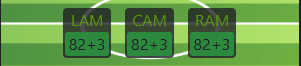  
`LAM`, `CAM`, `RAM` are positions in the atacking midfield and the first character indicates 'left', 'center' and 'right', the horizontal reference.

Therefore, even though the values are equal, both columns will be kept to facilitate future analysis.

### Columns with only one value

In [18]:
players.nunique().sort_values(ascending=True).head(10)

update                 1
fifa_edition           1
preferredfoot          2
acceleration_type      5
league_id             10
league                10
bodytype              10
job_title             12
contractvaliduntil    15
potential             43
dtype: int64

In [19]:
## `update` and `fifa_edition` have only one unique value. This value can be get by the `version` variable. So, these columns will be removed
players.drop(columns=["update", "fifa_edition"], inplace=True)

## Feature engineering

### Data types

In [20]:
print(players.dtypes.value_counts())

int64     64
object    20
Name: count, dtype: int64


In [21]:
display(players.select_dtypes(include=["int64"]).head(10))

,player_id,league_id,team_id,position,kitnumber,overallrating,potential,crossing,finishing,headingaccuracy,shortpassing,volleys,dribbling,curve,fk_accuracy,longpassing,ballcontrol,acceleration,sprintspeed,agility,reactions,balance,shotpower,jumping,stamina,strength,longshots,aggression,interceptions,vision,penalties,composure,defensiveawareness,standingtackle,slidingtackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,lineup_ls,lineup_st,lineup_rs,lineup_lw,lineup_lf,lineup_rf,lineup_rw,lineup_lam,lineup_cam,lineup_ram,lineup_lm,lineup_lcm,lineup_cm,lineup_rcm,lineup_rm,lineup_ldm,lineup_cdm,lineup_rdm,lineup_lb,lineup_lcb,lineup_cb,lineup_rcb,lineup_rb,lineup_gk
0,210257,13,10,20,31,87,87,20,14,14,65,18,30,39,20,68,45,64,63,60,85,48,68,79,44,78,18,38,27,70,65,70,29,15,8,87,82,91,85,86,43,43,43,43,45,45,43,52,52,52,50,54,54,54,50,48,48,48,39,39,39,39,39,87
1,188377,13,10,68,2,83,83,77,51,72,80,57,78,76,71,79,80,84,90,66,84,69,87,87,81,80,69,84,78,69,63,75,75,83,81,12,6,16,15,8,76,76,76,75,75,75,75,78,78,78,80,80,80,80,80,83,83,83,83,83,83,83,83,22
2,239818,13,10,39,3,88,88,54,29,87,85,32,64,46,48,81,75,59,64,62,89,56,74,86,78,90,26,88,87,64,45,86,90,90,87,7,8,13,7,12,64,64,64,61,62,62,61,68,68,68,69,76,76,76,69,87,87,87,83,88,88,88,83,21
3,229237,13,10,37,25,84,85,55,38,79,83,42,76,54,59,80,78,76,80,66,86,54,75,90,71,86,48,82,84,65,40,83,86,86,84,10,9,13,6,9,68,68,68,67,67,67,67,72,72,72,73,77,77,77,73,85,85,85,83,85,85,85,83,20
4,251517,13,10,69,24,84,87,73,68,80,81,60,79,74,59,76,81,80,79,68,85,67,81,90,79,83,74,86,83,70,61,81,84,85,84,5,8,6,9,11,80,80,80,76,77,77,76,79,79,79,80,81,81,81,80,85,85,85,85,87,87,87,85,20
5,186942,13,10,84,19,85,85,77,82,50,86,75,87,86,80,85,89,63,57,74,86,75,81,64,72,68,81,70,78,85,80,87,77,78,67,11,14,5,5,13,81,81,81,81,82,82,81,85,85,85,84,85,85,85,84,83,83,83,77,76,76,76,77,22
6,218667,13,10,84,20,87,87,84,78,54,90,78,92,84,67,82,91,83,69,95,89,92,79,67,93,54,79,78,73,86,64,89,70,76,68,9,10,14,12,9,82,82,82,86,85,85,86,87,87,87,87,87,87,87,87,83,83,83,81,74,74,74,81,22
7,237692,13,10,85,47,87,89,80,85,47,86,59,90,88,74,84,90,89,83,92,85,92,89,66,83,53,86,64,59,84,64,86,60,59,47,8,15,6,10,13,83,83,83,86,86,86,86,89,89,89,89,86,86,86,89,75,75,75,73,64,64,64,73,22
8,270409,13,10,79,26,82,88,82,76,45,81,63,87,80,55,70,84,90,87,90,79,76,69,62,73,45,67,45,25,80,62,74,26,30,36,9,12,8,9,12,77,77,77,82,80,80,82,84,84,84,85,77,77,77,85,58,58,58,60,46,46,46,60,21
9,239085,13,10,96,9,91,93,58,96,83,77,90,79,77,62,66,83,80,94,77,94,69,94,92,76,93,83,88,43,74,90,87,38,47,29,7,14,13,11,7,93,93,93,83,86,86,83,85,85,85,83,79,79,79,83,67,67,67,64,65,65,65,64,22


In [22]:
display(players.select_dtypes(include=["object"]).head(10))

,player,team,league,preferredfoot,joined,contractvaliduntil,birth_date,height,weight,job_title,nationality,net_worth,bodytype,releaseclause,acceleration_type,value,wage,specialities,transfermarkt_link,national_team_last_appearence
0,Ederson Santana de Moraes,Manchester City,ENG-Premier League,Left,"Jul 1, 2017",2026,1993-08-17,188 cm,86 kg,Goalkeeper,Brazil,EUR 53000000,Unique,€98.1M,Controlled Lengthy,€53M,€145K,NaN,https://www.transfermarkt.com/ederson/profil/s...,"Sep 12, 2018"
1,Kyle Walker,Manchester City,ENG-Premier League,Right,"Jul 14, 2017",2026,1990-05-28,183 cm,83 kg,Right back,England,EUR 13500000,Unique,€25M,Controlled Lengthy,€13.5M,€155K,NaN,https://www.transfermarkt.com/kyle-walker/prof...,"Dec 18, 2024"
2,Rúben Santos Gato Alves Dias,Manchester City,ENG-Premier League,Right,"Sep 29, 2020",2027,1997-05-14,187 cm,82 kg,Center back,Portugal,EUR 84000000,Normal (185+),€155.4M,Controlled Lengthy,€84M,€230K,"#Tackling ,#Tactician ,#Strength,#Complete def...",https://www.transfermarkt.com/ruben-dias/profi...,"Dec 18, 2024"
3,Manuel Akanji,Manchester City,ENG-Premier League,Right,"Sep 1, 2022",2027,1995-07-19,187 cm,91 kg,Center back,Switzerland,EUR 40000000,Unique,€77M,Controlled Lengthy,€40M,€170K,#Strength,https://www.transfermarkt.com/manuel-akanji/pr...,"Sep 25, 2021"
4,Joško Gvardiol,Manchester City,ENG-Premier League,Left,"Aug 5, 2023",2028,2002-01-23,185 cm,80 kg,Left back,Croatia,EUR 54500000,Normal (185+),€104.9M,Controlled Lengthy,€54.5M,€140K,NaN,https://www.transfermarkt.com/josko-gvardiol/p...,"Dec 18, 2024"
5,İlkay Gündoğan,Manchester City,ENG-Premier League,Right,"Aug 23, 2024",2025,1990-10-24,180 cm,80 kg,Center midfield,Germany,EUR 33000000,Normal (170-185),€61.1M,Controlled,€33M,€195K,#Dribbler,https://www.transfermarkt.com/ilkay-gundogan/p...,"Aug 7, 2024"
6,Bernardo Mota Carvalho e Silva,Manchester City,ENG-Premier League,Left,"Jul 1, 2017",2026,1994-08-10,173 cm,64 kg,Center midfield,Portugal,EUR 77500000,Lean (170-185),€143.4M,Explosive,€77.5M,€230K,"#Dribbler,#Playmaker ,#Acrobat,#Complete midfi...",https://www.transfermarkt.com/bernardo-silva/p...,"Dec 18, 2024"
7,Phil Foden,Manchester City,ENG-Premier League,Left,"Dec 6, 2016",2027,2000-05-28,171 cm,69 kg,Right winger,England,EUR 103500000,Unique,€199.2M,Explosive,€103.5M,€210K,"#Dribbler,#Distance shooter,#Acrobat",https://www.transfermarkt.com/phil-foden/profi...,"Dec 18, 2024"
8,Sávio Moreira de Oliveira,Manchester City,ENG-Premier League,Left,"Jul 18, 2024",2029,2004-04-10,176 cm,71 kg,Left winger,Brazil,EUR 47500000,Lean (170-185),€97.4M,Mostly Explosive,€47.5M,€115K,"#Dribbler,#Acrobat",https://www.transfermarkt.com/savinho/profil/s...,NaN
9,Erling Haaland,Manchester City,ENG-Premier League,Left,"Jul 1, 2022",2027,2000-07-21,195 cm,94 kg,Striker,Norway,EUR 172500000,Unique,€332.1M,Controlled Lengthy,€172.5M,€420K,"#Aerial threat,#Distance shooter,#Strength,#Cl...",https://www.transfermarkt.com/erling-haaland/p...,"Dec 18, 2024"


### Date features

The date features (except for `contractvaliduntil`) will be formatted as YYYY-mm-dd.  
`contractvaliduntil` will be formated as YYYY, for a while.

In [23]:
## Converting dates with named months to dates with numbers

_months_to_number = {
    "Jan": "01",
    "Feb": "02",
    "Mar": "03",
    "Apr": "04",
    "May": "05",
    "Jun": "06",
    "Jul": "07",
    "Aug": "08",
    "Sep": "09",
    "Oct": "10",
    "Nov": "11",
    "Dec": "12"
}

def convert_named_month_to_date(date: str) -> str:

    if not isinstance(date, str):
        return None
    month, day, year = date.strip().split(" ")
    day = day.split(",")[0]
    if len(day) == 1:
        day = f"0{day}"

    month = _months_to_number[month]

    return f"{year}-{month}-{day}"

players['joined'] = players['joined'].apply(convert_named_month_to_date)
players['national_team_last_appearence'] = players['national_team_last_appearence'].apply(convert_named_month_to_date)

players["joined"] = pd.to_datetime(players["joined"], format="%Y-%m-%d")
players["national_team_last_appearence"] = pd.to_datetime(players["national_team_last_appearence"], format="%Y-%m-%d")
players["birth_date"] = pd.to_datetime(players["birth_date"], format="%Y-%m-%d")

#### `contractvaliduntil`

In [24]:
players["contractvaliduntil"].value_counts()

contractvaliduntil
2025            1371
2026            1285
2027            1106
2028             757
2029             347
2024             346
Jun 30, 2025     340
2030              30
2031               9
Dec 31, 2024       6
Jun 30, 2026       3
2033               2
2032               2
Dec 31, 2025       2
Jul 31, 2025       1
Name: count, dtype: int64

In [25]:
## Checking players with `contractvaliduntil` as date
full_dates = ["Jun 30, 2025", "Dec 31, 2024", "Jun 30, 2026", "Dec 31, 2025", "Jul 31, 2025"]
players.loc[players["contractvaliduntil"].isin(full_dates)].head()

,player_id,player,team,league,league_id,team_id,preferredfoot,position,joined,contractvaliduntil,kitnumber,birth_date,height,weight,job_title,nationality,net_worth,bodytype,releaseclause,acceleration_type,overallrating,potential,value,wage,crossing,finishing,headingaccuracy,shortpassing,volleys,dribbling,curve,fk_accuracy,longpassing,ballcontrol,acceleration,sprintspeed,agility,reactions,balance,shotpower,jumping,stamina,strength,longshots,aggression,interceptions,vision,penalties,composure,defensiveawareness,standingtackle,slidingtackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,lineup_ls,lineup_st,lineup_rs,lineup_lw,lineup_lf,lineup_rf,lineup_rw,lineup_lam,lineup_cam,lineup_ram,lineup_lm,lineup_lcm,lineup_cm,lineup_rcm,lineup_rm,lineup_ldm,lineup_cdm,lineup_rdm,lineup_lb,lineup_lcb,lineup_cb,lineup_rcb,lineup_rb,lineup_gk,specialities,transfermarkt_link,national_team_last_appearence
69,202652,Raheem Sterling,Arsenal,ENG-Premier League,13,1,Right,83,NaT,"Jun 30, 2025",30,1994-12-08,172 cm,69 kg,Left midfield,England,EUR 20500000,Unique,NaN,Explosive,80,80,€20.5M,€120K,76,79,48,77,65,84,79,78,68,81,88,83,92,79,92,78,71,67,65,77,52,38,76,70,76,38,48,40,15,12,12,15,9,79,79,79,80,80,80,80,80,80,80,80,76,76,76,80,63,63,63,63,55,55,55,63,23,#Acrobat,https://www.transfermarkt.com/raheem-sterling/...,2023-09-22
73,194404,Norberto Murara Neto,Arsenal,ENG-Premier League,13,1,Right,11,NaT,"Jun 30, 2025",32,1989-07-19,190 cm,83 kg,Goalkeeper,Brazil,EUR 2400000,Lean (185+),NaN,Controlled,78,78,€2.4M,€41K,11,15,14,37,12,18,12,13,42,23,55,50,58,78,48,55,68,40,62,20,40,15,43,22,60,17,14,15,80,72,73,76,82,33,33,33,30,32,32,30,35,35,35,34,36,36,36,34,34,34,34,30,30,30,30,30,78,NaN,https://www.transfermarkt.com/neto/profil/spie...,2018-09-12
88,233049,Jadon Sancho,Chelsea,ENG-Premier League,13,5,Right,79,NaT,"Jun 30, 2025",19,2000-03-25,180 cm,76 kg,Left midfield,England,EUR 43500000,Unique,NaN,Mostly Explosive,82,86,€43.5M,€100K,75,75,40,84,78,91,83,65,65,87,83,76,90,81,90,72,61,75,53,70,35,33,84,74,83,38,35,25,7,11,10,11,13,77,77,77,82,81,81,82,86,86,86,84,79,79,79,84,61,61,61,60,48,48,48,60,21,"#Dribbler,#Acrobat",https://www.transfermarkt.com/jadon-sancho/pro...,2022-10-07
164,212188,Timo Werner,Tottenham Hotspur,ENG-Premier League,13,18,Right,83,NaT,"Jun 30, 2025",16,1996-03-06,180 cm,76 kg,Left winger,Germany,EUR 17500000,Unique,NaN,Mostly Explosive,79,79,€17.5M,€61K,68,74,75,77,80,80,70,58,55,78,94,91,78,77,76,83,85,81,64,74,63,37,68,78,72,39,20,24,9,9,8,15,9,79,79,79,78,79,79,78,79,79,79,79,72,72,72,79,58,58,58,60,53,53,53,60,21,#Speedster,https://www.transfermarkt.com/timo-werner/prof...,2023-08-11
242,234153,Carlos Soler Barragán,West Ham United,ENG-Premier League,13,19,Right,76,NaT,"Jun 30, 2025",4,1997-01-02,180 cm,76 kg,Center midfield,Spain,EUR 12000000,Normal (170-185),NaN,Controlled Explosive,77,78,€12M,€66K,77,75,56,80,66,78,80,76,77,79,76,74,75,75,73,77,73,72,69,74,65,72,79,74,76,67,73,68,6,14,7,13,11,76,76,76,77,77,77,77,78,78,78,78,78,78,78,78,76,76,76,75,72,72,72,75,20,NaN,https://www.transfermarkt.com/carlos-soler/pro...,2023-03-07


In [26]:
## Checking if the end of the contract is related to the league (if the season ends in the middle of the year or in december)
players.loc[players["contractvaliduntil"].isin(full_dates)][["contractvaliduntil", "league"]].value_counts()


contractvaliduntil  league                 
Jun 30, 2025        ITA-Serie A                64
                    ESP-La Liga                53
                    SAU-Pro League             39
                    FRA-Ligue 1                35
                    NED-Eredivisie             34
                    POR-Primeira Liga          32
                    TUR-Süper Lig              31
                    GER-Bundesliga             26
                    ENG-Premier League         24
Dec 31, 2024        USA-Major League Soccer     6
Dec 31, 2025        USA-Major League Soccer     2
Jun 30, 2026        GER-Bundesliga              2
Jun 30, 2025        USA-Major League Soccer     2
Jul 31, 2025        USA-Major League Soccer     1
Jun 30, 2026        ITA-Serie A                 1
Name: count, dtype: int64

European and Saudi Arabia leagues' players use to end their contract in the middle of the year. MLS players show no pattern, 8 of the available players end their contract in December, while 3 players' contracts ends in June/July.

It will be created complete date (including day and month) to the end of the contract of the players.

For the players in European or Saudi Arabia leagues, the default end day and month will be **June 30th**.

On the 2024 season, the MLS ended on December 7th, so December will be defined as default month to the end of the MLS players' contract, therefore, for MLS players the default end day and month will be **December 31th**.

In [27]:
december_leagues = ["USA-Major League Soccer"]

def create_end_of_contract(league: str, contract_end: str | int) -> str:
    try:
        contract_end = int(contract_end)
        month_day = "Dec 31," if league in december_leagues else "Jun 30,"
        return f"{month_day} {contract_end}"
    except:
        return contract_end

players['contractvaliduntil'] = players.apply(lambda x: create_end_of_contract(x.league, x.contractvaliduntil), axis=1)
players['contractvaliduntil'] = players['contractvaliduntil'].apply(convert_named_month_to_date)
players["contractvaliduntil"] = pd.to_datetime(players["contractvaliduntil"], format="%Y-%m-%d")

#### Creating `ages` features

In [28]:
from datetime import timedelta

players["contract_duration"] = round((players["contractvaliduntil"] - players["joined"]) / timedelta(days=365), 1)
players["age_hire"] = round((players["joined"] - players["birth_date"]) / timedelta(days=365), 1)
players["age_end_contract"] = round((players["contractvaliduntil"] - players["birth_date"]) / timedelta(days=365), 1)

## The dataset get data from December 18, 2024. So the `current_age` of the players, will be calculated based on this date
players["current_age"] = round((pd.to_datetime("2024-12-18", format="%Y-%m-%d") - players["birth_date"]) / timedelta(days=365), 1)

### `height` and `weight`

In [29]:
players["height"] = players["height"].str.replace("cm", "").astype(int)
players["weight"] = players["weight"].str.replace("kg", "").astype(int)

#### Monetary features

In [30]:
## Standardizing `net_worth`
players["net_worth"] = players["net_worth"].str.replace("EUR ", "").astype(int)

In [31]:
def convert_monetary_value(value: str) -> int:
    if not isinstance(value, str):
        return None
    _value = float(value.replace("€", "").replace("M", "").replace("K", ""))
    if "M" in value:
        return int(_value * 1000000)
    if "K" in value:
        return int(_value * 1000)

players['releaseclause'] = players['releaseclause'].apply(convert_monetary_value)
players['value'] = players['value'].apply(convert_monetary_value)
players['wage'] = players['wage'].apply(convert_monetary_value)

In [32]:
## It looks like `net_worth` and `value` are the same feature
players.loc[players["net_worth"].astype(float) != players["value"]][["net_worth", "value"]].value_counts(dropna=False)

net_worth  value    
4100000    4099999.0    28
0          NaN           2
Name: count, dtype: int64

In [33]:
# Yes, they are the same feature. So, `value` will be removed
players.drop(columns=["value"], inplace=True)

In [34]:
display(players.head(10))

,player_id,player,team,league,league_id,team_id,preferredfoot,position,joined,contractvaliduntil,kitnumber,birth_date,height,weight,job_title,nationality,net_worth,bodytype,releaseclause,acceleration_type,overallrating,potential,wage,crossing,finishing,headingaccuracy,shortpassing,volleys,dribbling,curve,fk_accuracy,longpassing,ballcontrol,acceleration,sprintspeed,agility,reactions,balance,shotpower,jumping,stamina,strength,longshots,aggression,interceptions,vision,penalties,composure,defensiveawareness,standingtackle,slidingtackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,lineup_ls,lineup_st,lineup_rs,lineup_lw,lineup_lf,lineup_rf,lineup_rw,lineup_lam,lineup_cam,lineup_ram,lineup_lm,lineup_lcm,lineup_cm,lineup_rcm,lineup_rm,lineup_ldm,lineup_cdm,lineup_rdm,lineup_lb,lineup_lcb,lineup_cb,lineup_rcb,lineup_rb,lineup_gk,specialities,transfermarkt_link,national_team_last_appearence,contract_duration,age_hire,age_end_contract,current_age
0,210257,Ederson Santana de Moraes,Manchester City,ENG-Premier League,13,10,Left,20,2017-07-01,2026-06-30,31,1993-08-17,188,86,Goalkeeper,Brazil,53000000,Unique,98100000.0,Controlled Lengthy,87,87,145000.0,20,14,14,65,18,30,39,20,68,45,64,63,60,85,48,68,79,44,78,18,38,27,70,65,70,29,15,8,87,82,91,85,86,43,43,43,43,45,45,43,52,52,52,50,54,54,54,50,48,48,48,39,39,39,39,39,87,NaN,https://www.transfermarkt.com/ederson/profil/s...,2018-09-12,9.0,23.9,32.9,31.4
1,188377,Kyle Walker,Manchester City,ENG-Premier League,13,10,Right,68,2017-07-14,2026-06-30,2,1990-05-28,183,83,Right back,England,13500000,Unique,25000000.0,Controlled Lengthy,83,83,155000.0,77,51,72,80,57,78,76,71,79,80,84,90,66,84,69,87,87,81,80,69,84,78,69,63,75,75,83,81,12,6,16,15,8,76,76,76,75,75,75,75,78,78,78,80,80,80,80,80,83,83,83,83,83,83,83,83,22,NaN,https://www.transfermarkt.com/kyle-walker/prof...,2024-12-18,9.0,27.1,36.1,34.6
2,239818,Rúben Santos Gato Alves Dias,Manchester City,ENG-Premier League,13,10,Right,39,2020-09-29,2027-06-30,3,1997-05-14,187,82,Center back,Portugal,84000000,Normal (185+),155400000.0,Controlled Lengthy,88,88,230000.0,54,29,87,85,32,64,46,48,81,75,59,64,62,89,56,74,86,78,90,26,88,87,64,45,86,90,90,87,7,8,13,7,12,64,64,64,61,62,62,61,68,68,68,69,76,76,76,69,87,87,87,83,88,88,88,83,21,"#Tackling ,#Tactician ,#Strength,#Complete def...",https://www.transfermarkt.com/ruben-dias/profi...,2024-12-18,6.8,23.4,30.1,27.6
3,229237,Manuel Akanji,Manchester City,ENG-Premier League,13,10,Right,37,2022-09-01,2027-06-30,25,1995-07-19,187,91,Center back,Switzerland,40000000,Unique,77000000.0,Controlled Lengthy,84,85,170000.0,55,38,79,83,42,76,54,59,80,78,76,80,66,86,54,75,90,71,86,48,82,84,65,40,83,86,86,84,10,9,13,6,9,68,68,68,67,67,67,67,72,72,72,73,77,77,77,73,85,85,85,83,85,85,85,83,20,#Strength,https://www.transfermarkt.com/manuel-akanji/pr...,2021-09-25,4.8,27.1,32.0,29.4
4,251517,Joško Gvardiol,Manchester City,ENG-Premier League,13,10,Left,69,2023-08-05,2028-06-30,24,2002-01-23,185,80,Left back,Croatia,54500000,Normal (185+),104900000.0,Controlled Lengthy,84,87,140000.0,73,68,80,81,60,79,74,59,76,81,80,79,68,85,67,81,90,79,83,74,86,83,70,61,81,84,85,84,5,8,6,9,11,80,80,80,76,77,77,76,79,79,79,80,81,81,81,80,85,85,85,85,87,87,87,85,20,NaN,https://www.transfermarkt.com/josko-gvardiol/p...,2024-12-18,4.9,21.5,26.5,22.9
5,186942,İlkay Gündoğan,Manchester City,ENG-Premier League,13,10,Right,84,2024-08-23,2025-06-30,19,1990-10-24,180,80,Center midfield,Germany,33000000,Normal (170-185),61100000.0,Controlled,85,85,195000.0,77,82,50,86,75,87,86,80,85,89,63,57,74,86,75,81,64,72,68,81,70,78,85,80,87,77,78,67,11,14,5,5,13,81,81,81,81,82,82,81,85,85,85,84,85,85,85,84,83,83,83,77,76,76,76,77,22,#Dribbler,https://www.transfermarkt.com/ilkay-gundogan/p...,2024-08-07,0.9,33.9,34.7,34.2
6,218667,Bernardo Mota Carvalho e Silva,Manchester City,ENG-Premier League,13,10,Left,84,2017-07-01,2026-06-30,20,1994-08-10,173,64,Center midfield,Portugal,77500000,Lean (170-185),143400000.0,Explosive,87,87,230000.0,84,78,54,90,78

### Players position
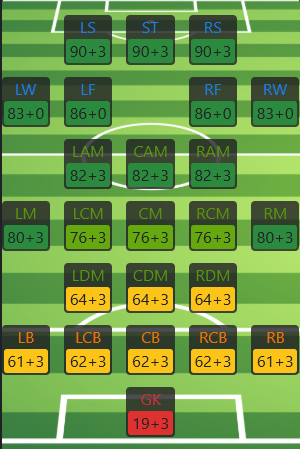

#### Mapping job_title into lineup position

In [35]:
players["job_title"].unique()

array(['Goalkeeper', 'Right back', 'Center back', 'Left back',
       'Center midfield', 'Right winger', 'Left winger', 'Striker',
       'Central defensive midfielder', 'Central attacking midfielder',
       'Right midfield', 'Left midfield'], dtype=object)

In [36]:
_map_job_title_to_position = {
    "Goalkeeper": "GK",
    "Center back": "CB",
    "Right back": "RB",
    "Left back": "LB",
    "Central defensive midfielder": "CDM",
    "Center midfield": "CM",
    "Right midfield": "RM",
    "Left midfield": "LM",
    "Central attacking midfielder": "CAM",
    "Right winger": "RW",
    "Left winger": "LW",
    "Striker": "ST"
}

players["position_lineup"] = players["job_title"].map(_map_job_title_to_position)

In [37]:
## Creating a dataset with positions' features
positions = pd.DataFrame()
positions["job_title"] = _map_job_title_to_position.keys()
positions["position"] = _map_job_title_to_position.values()

## Creating coordinates for the positions. The coordinates are based on the field's width (5) and height (7)
positions["x"] = [3, 3, 5, 1, 3, 3, 5, 1, 3, 5, 1, 3]
positions["y"] = [1, 2, 2, 2, 3, 4, 4, 4, 5, 6, 6, 7]

_map_positions_depth = {
    "Goalkeeper": "Goalkeeper",
    "Center back": "Defensive",
    "Right back": "Defensive",
    "Left back": "Defensive",
    "Central defensive midfielder": "Mid-defensive",
    "Center midfield": "Middle",
    "Right midfield": "Middle",
    "Left midfield": "Middle",
    "Central attacking midfielder": "Mid-attacking",
    "Right winger": "Attacking",
    "Left winger": "Attacking",
    "Striker": "Attacking"
}

_map_positions_width = {
    "Goalkeeper": "Goalkeeper",
    "Center back": "Center",
    "Right back": "Right",
    "Left back": "Left",
    "Central defensive midfielder": "Center",
    "Center midfield": "Center",
    "Right midfield": "Right",
    "Left midfield": "Left",
    "Central attacking midfielder": "Center",
    "Right winger": "Right",
    "Left winger": "Left",
    "Striker": "Center"
}

positions["depth"] = positions["job_title"].map(_map_positions_depth)
positions["width"] = positions["job_title"].map(_map_positions_width)
positions.to_csv(f"{version_directory}positions.csv", index=False)

## Saving the preprocessed data

In [38]:
players.to_csv(f"{version_directory}players.csv", index=False)